# Figure 1: Impact velocities

This notebook reads in the collision history from a pkdgrav N-body simulation of planet formation and plots a histogram of the planetesimal collision history (Fig. 1A). This example calculation is a Grand Tack simulation (022GTJf6hgas) from {cite}`Carter_Stewart_2022`.

Fig. 1B presents the critical impact velocities for the onset of vaporization of silicate and ice and compares them to the escape velocity and catastrophic disruption critical velocity.



In [18]:
import matplotlib
matplotlib.rc('text',usetex=False)
import matplotlib.pyplot as plt
#import numpy as npy
import numpy as np

simdir = './data/' # sim dir path
plotdir = './plots/'

# Correct velocities to realistic densities?
correct_v = True

real_rho = 2.
sim_rho=2.
expfac=6.

In [19]:
def readcolllog(fname=simdir+'ss.coll.txt'):
    """
    readcolllog(<fname=file>)
    - Read standard ss collision log
    - returns a tuple of arrays
    """
    t=[]
    id1=[]
    id2=[]
    m1=[]
    m2=[]
    x1=[]
    x2=[]
    y1=[]
    y2=[]
    z1=[]
    z2=[]
    vx1=[]
    vx2=[]
    vy1=[]
    vy2=[]
    vz1=[]
    vz2=[]
    mlr = []
    mslr = []
    nfrag = []
    mfrag = []
    m2dust = []
    with open(fname) as fo:
        lines = fo.readlines()
        for j in range(len(lines)):
            if lines[j].count('PLANETESIMAL')>1:
                mf = 0
                nf = 0
                mf0 = 0
                mf1 = 0
                mdeb = 0
                t.append(float(lines[j].split('=')[1]))
                d1 = lines[j+1].replace('=',',').split(',')
                d2 = lines[j+2].replace('=',',').split(',')
                id1.append(float(d1[7]))
                m1.append(float(d1[9]))
                x1.append(float(d1[17].strip('(')))
                y1.append(float(d1[18]))
                z1.append(float(d1[19].strip(')')))
                vx1.append(float(d1[21].strip('(')))
                vy1.append(float(d1[22]))
                vz1.append(float(d1[23].strip(')')))
                id2.append(float(d2[7]))
                m2.append(float(d2[9]))
                x2.append(float(d2[17].strip('(')))
                y2.append(float(d2[18]))
                z2.append(float(d2[19].strip(')')))
                vx2.append(float(d2[21].strip('(')))
                vy2.append(float(d2[22]))
                vz2.append(float(d2[23].strip(')')))
                d3 = lines[j+3]
                if d3.count('MERGE') + d3.count('BOUNCE') + d3.count('FRAG') >0:
                    d4 = lines[j+4].replace('=',',').split(',')
                    mf0 = float(d4[9])
                    mf += mf0
                    nf += 1
                if d3.count('BOUNCE') + d3.count('FRAG') >0:
                    d5 = lines[j+5].replace('=',',').split(',')
                    mf1 = float(d5[9])
                    mf += mf1
                    nf += 1
                if d3.count('FRAG') >0:
                    dd = lines[j+3+nf].replace('=',',').split(',')
                    while dd.count('***out')>0:
                        mf += float(dd[9])
                        nf += 1
                mlr.append(mf0)
                mslr.append(mf1)
                mfrag.append(mf)
                nfrag.append(nf)
                if abs((float(d1[9]) + float(d2[9]) - mf)/(float(d1[9]) + float(d2[9])))>1e-5:
                    mdeb = float(d1[9]) + float(d2[9]) - mf
                m2dust.append(mdeb)
            else:
                continue
    return np.array(t),np.array(id1),np.array(id2),np.array(m1),np.array(m2),np.array(x1),np.array(x2),np.array(y1),np.array(y2),np.array(z1),np.array(z2),np.array(vx1),np.array(vx2),np.array(vy1),np.array(vy2),np.array(vz1),np.array(vz2),np.array(mlr),np.array(mslr),np.array(nfrag),np.array(mfrag),np.array(m2dust)

In [20]:
import os

file_path = './data/ss.coll.txt'
if os.path.exists(file_path):
    print("The data file exists: ./data/ss.coll.txt")
else:
    print("WARNING!")
    print("The data file does not exist: ./data/ss.coll.txt")
    print("Please unzip the file ./data/ss.coll.txt.gz")

The data file exists: ./data/ss.coll.txt


In [21]:
# read data
# in the GitHub repository, you need to unzip the data file
# check for unzipped file

t,id1,id2,m1,m2,x1,x2,y1,y2,z1,z2,vx1,vx2,vy1,vy2,vz1,vz2,mlr,mslr,nfrag,mfrag,m2dust = readcolllog(fname=simdir+'ss.coll.txt')

In [29]:
# calculate velocity

v = np.sqrt((vx1-vx2)**2 + (vy1-vy2)**2 + (vz1-vz2)**2)
v *= 1.5e8/(365.25*24*3600/2./np.pi)
v.mean()

msun = 1.9891e33
G = 6.67e-8


# velocity correction
if correct_v:
    infl_rho = sim_rho/(expfac**3)
    r1=np.power((3*msun*m1/(real_rho*4*np.pi)),(1./3.))
    r2=np.power((3*msun*m2/(real_rho*4*np.pi)),(1./3.))
    #rlr=np.power((3*msun*mlr/(real_rho*4*np.pi)),(1./3.))
    #rslr=np.power((3*msun*mslr/(real_rho*4*np.pi)),(1./3.))
    ve = np.sqrt( 2*G*(m1+m2)*msun / (r1+r2) )
    correctedv = np.sqrt( (v*1.e5)*(v*1.e5) + (1-(infl_rho/real_rho))*ve*ve ) / 1.e5 # cm/s to km/s
    #print(v,correctedv)
    v = correctedv

    
print(len(v))
ng1 = np.where(v > 1)[0] # how many greater than 1 km/s
print(len(ng1), len(ng1)/len(v))
ng1 = np.where(v > 2)[0] # how many greater than 2 km/s
print(len(ng1), len(ng1)/len(v))


129946
74541 0.5736305850122358
52700 0.4055530758930633


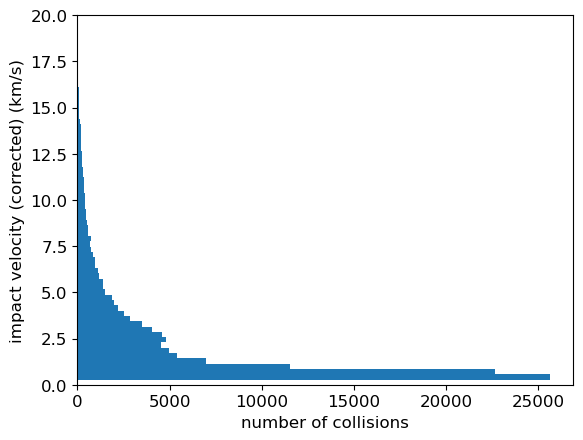

In [27]:
plt.hist(v,bins=280,orientation='horizontal')
plt.ylabel('impact velocity (corrected) (km/s)')
plt.xlabel('number of collisions')
plt.ylim(0,20)
plt.show()

In [30]:

# set up impact velocity array (used as Vesc to build Rt and Mt of targets)
vimax  = 20000 # m/s
nvi    = 200 # number of vi points
vi = np.linspace(0,vimax,nvi)
vi[0]=vi[1]/2 # don't have 0 impact velocity

# set up independent up array for the Hugoniots for all the materials
upmax  = 20000 # m/s
nup    = 50000 # number of up points
up = np.linspace(0,upmax,nup)

# Fundamental constants
G=6.67e-11 # mks
Msun = 1.98855e30 # kg
R = 8.314 # J/K/mol Gas constant

#----------------------------------------------------------------
# calc equivalent target radius for Vi=Vesc and bulk density of 'rock'
rhorock=3000.0 # kg/m3
rt = np.sqrt( (3 * vi**2) / (4 * np.pi * 2 * G * rhorock) )
rtice = np.sqrt( (3 * vi**2) / (4 * np.pi * 2 * G * 1000.) )
mt = (4. * np.pi / 3.) * rhorock * rt**3.

# calculate the critical equal mass disruption velocity from LS12 V*_gamma=1
rc1 = np.sqrt( (3 * vi**2) / (4 * np.pi * 2 * G * 1000.0) )
cstar_fluid = 1.9
vstar_fluid = np.sqrt((32. * np.pi * cstar_fluid) / 5.) * np.sqrt(1000.0 * G) * rc1
cstar_solid = 5.0
vstar_solid = np.sqrt((32. * np.pi * cstar_solid) / 5.) * np.sqrt(1000.0 * G) * rc1

# critical impact velocities for onset of vaporization
ice_vcrit = 1000.0 # Stewart et al. 2008
rock_vcrit = 10000.0 # Davies et al. 2020 300K forsterite

#--------------------------------------------------------------------------------
# critical eccentricities
# set up semi-major axis array
AU2m = 1.496e11
semimax  = 25.*AU2m # m
nsemi    = 250 # number of semi points
semiarr = np.linspace(0,semimax,nsemi)
semiarr[0]=semiarr[1]/2. # don't have a=0
vkeparr = np.sqrt(G*Msun/semiarr)

eifact = 1. + (.5*.5) # i=0.5e
ice_ecrit = np.sqrt(((ice_vcrit/vkeparr)**2.) / eifact)
rock_ecrit = np.sqrt(((rock_vcrit/vkeparr)**2.) / eifact)



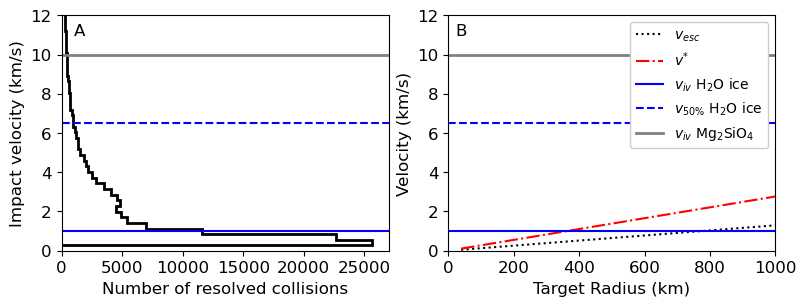

In [31]:
figure, ax = plt.subplots(1, 2,figsize=(8,3)) 
plt.rcParams.update({'font.size': 12})

i=0
ax[i].hist(v,bins=280,orientation='horizontal',histtype='step',color='k',linewidth=2)
ax[i].set_ylabel('Impact velocity (km/s)')
ax[i].set_xlabel('Number of resolved collisions')
ax[i].set_ylim(0,12)
ax[i].set_xlim(0,27000)
ax[i].plot([0,27000],[ice_vcrit/1.e3,ice_vcrit/1.e3],color='blue')
ax[i].plot([0,27000],[6.5,6.5],'--',color='blue',label='$v_{50\%}$ H$_2$O ice')
ax[i].plot([0,27000],[rock_vcrit/1.e3,rock_vcrit/1.e3],'-',color='grey',linewidth=2)
ax[i].text(1000,11.,'A')

#Plotting
i=1
ax[i].plot(rt/1.e3,vi/1.e3,':',color='k',label='$v_{esc}$')
ax[i].plot(rt/1.e3,vstar_fluid/1.e3,'-.',color='red',label='$v^{*}$')
ax[i].plot([0,1000],[ice_vcrit/1.e3,ice_vcrit/1.e3],color='blue',label='$v_{iv}$ H$_2$O ice')
ax[i].plot([0,1000],[6.5,6.5],'--',color='blue',label='$v_{50\%}$ H$_2$O ice')
ax[i].plot([0,1000],[rock_vcrit/1.e3,rock_vcrit/1.e3],'-',color='grey',linewidth=2,label='$v_{iv}$ Mg$_2$SiO$_4$')
ax[i].set_xlabel('Target Radius (km)')
ax[i].set_ylabel('Velocity (km/s)')
ax[i].set_ylim(0,12)
ax[i].set_xlim(0.,1000)
ax[i].legend(loc='upper right',framealpha=1,fontsize=10)#, fontsize='medium')
ax[i].text(20,11.,'B')

plt.tight_layout(pad=0.4,w_pad=0.5,h_pad=1.0)
plt.savefig(plotdir+'Fig1-vels-imp-disrupt.pdf', format='pdf', dpi=1000,transparent=True)

#plt.show()